In [5]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

### For download the dataset, please visit https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

## Image generator

In [6]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = 'Covid19-dataset/train'
TESTING_DIR = 'Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


## Image demonstration

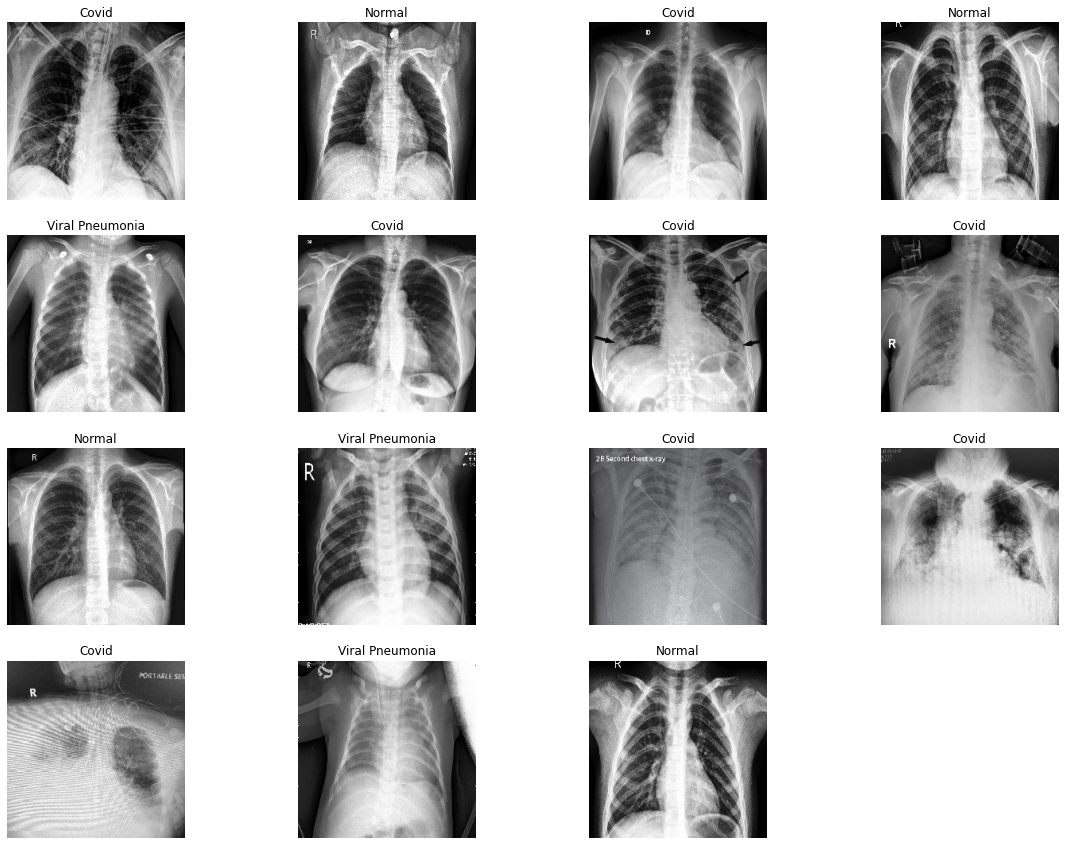

In [7]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

## Building up the VGG16 model

In [8]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.2078 - acc: 0.3865
Epoch 1: acc improved from -inf to 0.38645, saving model to model\vgg16_best.h5
4/4 [==============================] - 26s 6s/step - loss: 1.2078 - acc: 0.3865 - val_loss: 1.0450 - val_acc: 0.3939
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.1162 - acc: 0.4343
Epoch 2: acc improved from 0.38645 to 0.43426, saving model to model\vgg16_best.h5
4/4 [==============================] - 24s 6s/step - loss: 1.1162 - acc: 0.4343 - val_loss: 0.9682 - val_acc: 0.3939
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.9845 - acc: 0.5219
Epoch 3: acc improved from 0.43426 to 0.52191, saving model to model\vgg16_best.h5
4/4 [==============================] - 23s 6s/step - loss: 0.9845 - acc: 0.5219 - val_loss: 0.8984 - val_acc: 0.6515
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.9071 - acc: 0.5339
Epoch 4: acc improved from 0.52191 to 0.53386, saving m

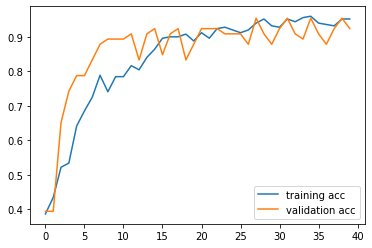

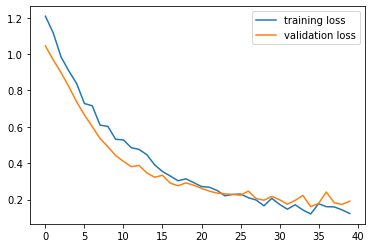

In [10]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [11]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 5s 152ms/step - loss: 0.1615 - acc: 0.9545


,Train,Val
Loss,0.099305,0.161507
Acc,0.968127,0.954545


3/3 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93        20
         1.0       0.95      0.90      0.92        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



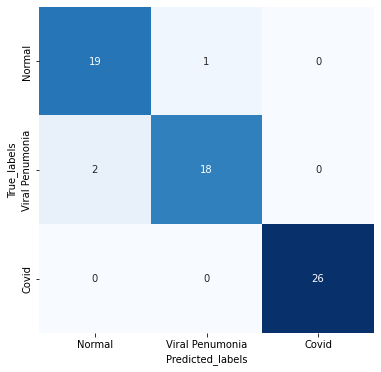

In [12]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

## Show wrong classified images

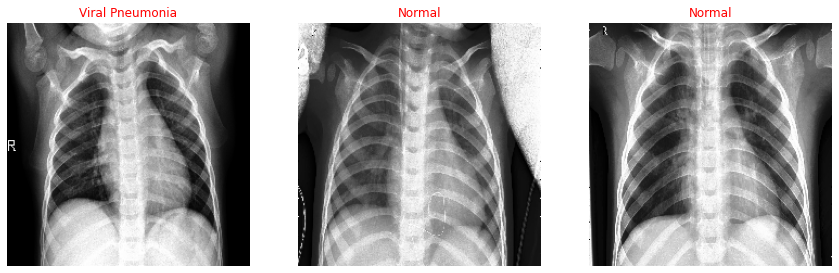

In [13]:
#Extract wrong classification index
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

## Adding image augmentation

Found 251 images belonging to 3 classes.


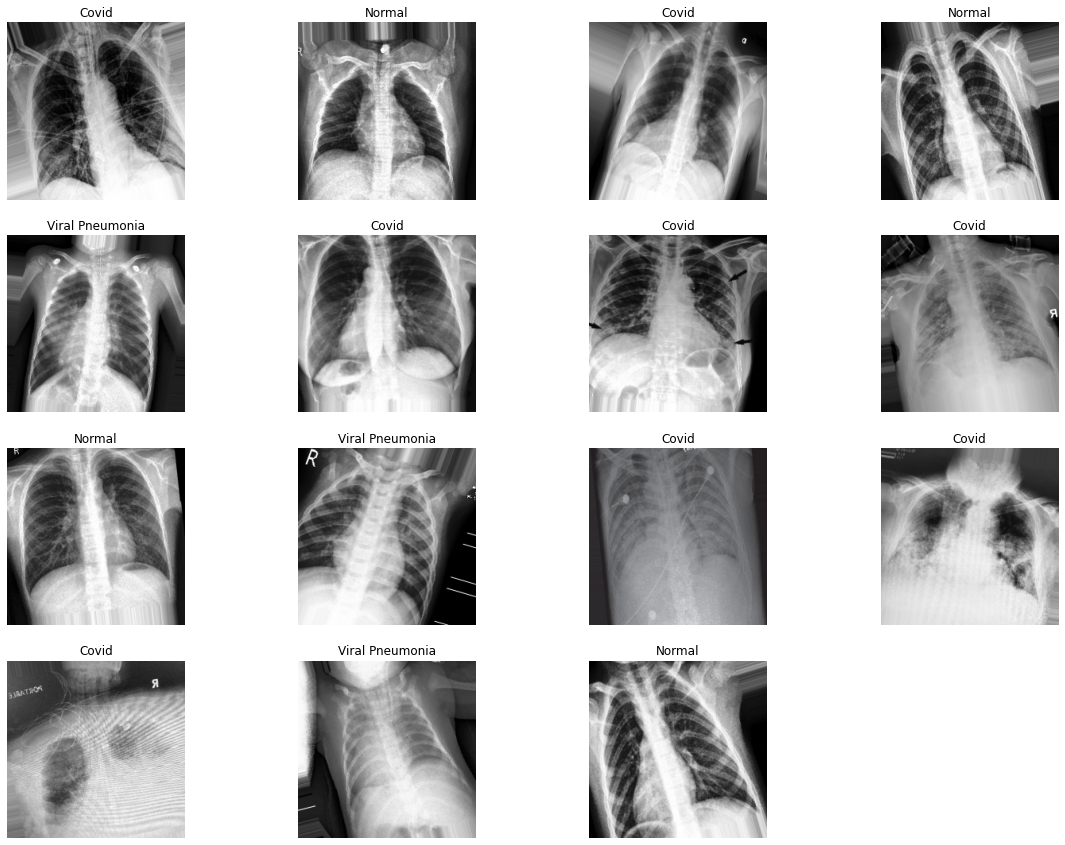

In [14]:
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=batch_size,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = generate_data_augmented(TRAINING_DIR)

image_plot(aug_train_generator,15)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        aug_train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=60, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/60
4/4 [==============================] - ETA: 0s - loss: 0.3100 - acc: 0.8845
Epoch 1: acc improved from -inf to 0.88446, saving model to model\vgg16_best.h5
4/4 [==============================] - 27s 7s/step - loss: 0.3100 - acc: 0.8845 - val_loss: 0.1971 - val_acc: 0.9394
Epoch 2/60
4/4 [==============================] - ETA: 0s - loss: 0.3256 - acc: 0.8685
Epoch 2: acc did not improve from 0.88446
4/4 [==============================] - 24s 6s/step - loss: 0.3256 - acc: 0.8685 - val_loss: 0.1642 - val_acc: 0.9697
Epoch 3/60
4/4 [==============================] - ETA: 0s - loss: 0.3268 - acc: 0.8845
Epoch 3: acc did not improve from 0.88446
4/4 [==============================] - 24s 6s/step - loss: 0.3268 - acc: 0.8845 - val_loss: 0.1729 - val_acc: 0.9545
Epoch 4/60
4/4 [==============================] - ETA: 0s - loss: 0.2947 - acc: 0.8805
Epoch 4: acc did not improve from 0.88446
4/4 [==============================] - 23s 6s/step - loss: 0.2947 - acc: 0.8805 - val_loss: 0.2

In [16]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 5s 170ms/step - loss: 0.1059 - acc: 0.9848


,Train,Val
Loss,0.054979,0.105868
Acc,0.984064,0.984848


## Final model evaluation
### For training data:

8/8 [==============================] - 16s 2s/step
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        70
         1.0       0.99      0.96      0.97        70
         2.0       1.00      1.00      1.00       111

    accuracy                           0.98       251
   macro avg       0.98      0.98      0.98       251
weighted avg       0.98      0.98      0.98       251



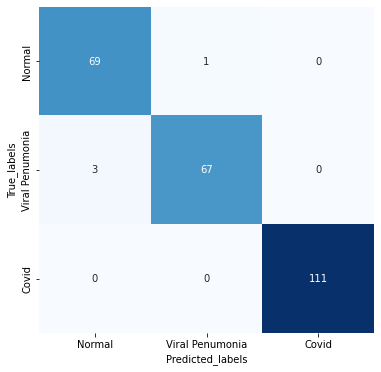

In [17]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

### For testing data:

3/3 [==============================] - 4s 1s/step
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.95      1.00      0.98        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



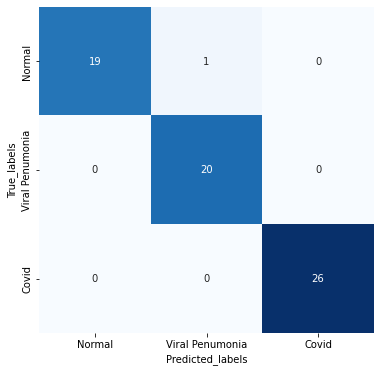

In [18]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))